In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time

from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve

In [10]:
total_start_time = time.time()

## Importing Data

In [11]:
df_raw = pd.read_csv("hour.csv", index_col = 'instant')

## Data Exploration

In this section we will use different methods to understand our initial data better. This will give us information for building our first baseline model.

#### Looking at Size and Data Types

In [12]:
# What does this dataset look like?
print(f"Number of features: {df_raw.shape[1]}")
print(f"Number of rows: {df_raw.shape[0]}")

Number of features: 10
Number of rows: 17379


In [13]:
# looking for the types of the data
print(f"Types of data in dataset:\n\n{df_raw.dtypes}")

Types of data in dataset:

dteday         object
hr              int64
weathersit     object
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


In [14]:
# aggregate columns by type
object_features = df_raw.select_dtypes(include=["object"])
numeric_features = df_raw.select_dtypes(include=["int64", "float64"])

print(f"Number of numeric features: {len(numeric_features.columns)}")
print(f"Number of object features: {len(object_features.columns)}")

Number of numeric features: 8
Number of object features: 2


In [15]:
# Looking at the data itself
df_raw.head(1)

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16


### Finding Outliers

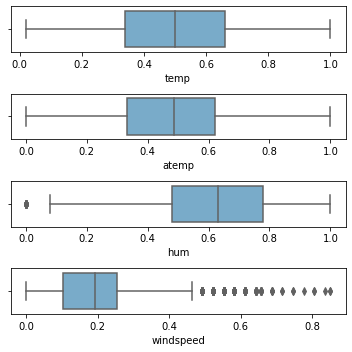

In [16]:
# Creating Box Plots
# Here we removed cnt, casual and registered because these are the target features
fig, axes = plt.subplots(len(numeric_features.columns[1:-3]), 1, figsize=(5,5))

for i, col in enumerate(numeric_features.columns.values[1:-3]):
    sns.boxplot(x=df_raw[col], palette='Blues_r', ax=axes[i])
fig.tight_layout()

Here we see that the features 'hum' and 'windspeed' have outliers within them, specially with windspeed. We need to take this into account when transforming the data before feeding it into our models. Heavily skewed data can have a strong effect on some models, specially with regression-based models.

#### Finding Missing Values

In [17]:
print(f"Number of missing values:\n{df_raw.isna().sum()}")

Number of missing values:
dteday          0
hr              0
weathersit    100
temp           99
atemp         100
hum           100
windspeed     100
casual          0
registered      0
cnt             0
dtype: int64


Here we can see that the missing values are a very small percentage of the total values in the data. Due to this, we know that the imputation method we chose will not have a major impact on how our models perform.

## Understanding How Features Interact

### Correlation of Features

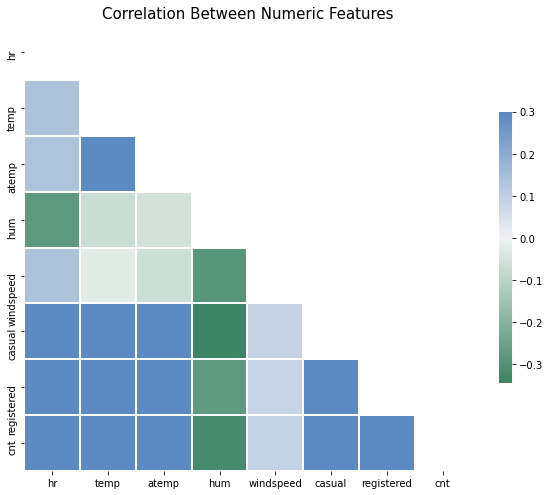

In [18]:
# Plotting correlations as a heatmap

# Getting correlation values
corr = df_raw.corr()

# Generating a mask so that the only one half of the square has values
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 10))

# Creatingcustom colormap
cmap = sns.diverging_palette(150, 250, n=10, center="light", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
graph = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5})

# Adding title to figure
ax.set_title("Correlation Between Numeric Features", fontsize = 15)
plt.show()

#### Pair Plot

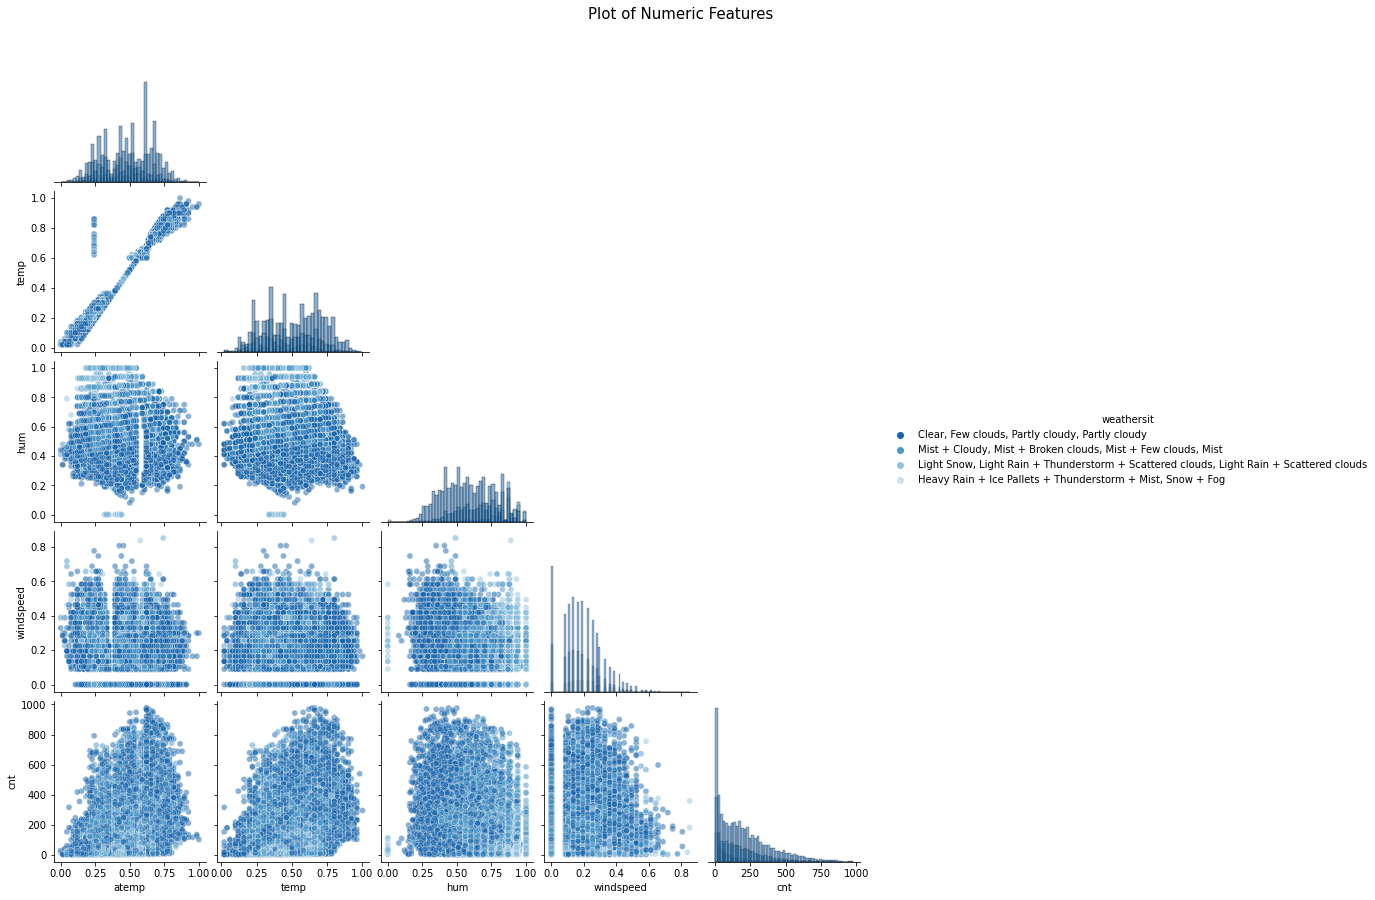

In [19]:
# Plotting Numeric Features by Weather Situation

# Creating pair plot
graph = sns.pairplot(data = df_raw, 
                     x_vars=["atemp", "temp", 'hum', 'windspeed',"cnt"],
                     y_vars=["atemp", "temp", 'hum', 'windspeed',"cnt"],
                     hue='weathersit',
                     palette='Blues_r',
                     diag_kind="hist",
                     corner=True,
                     plot_kws={'alpha': 0.5})

# Adding title to figure
graph.fig.suptitle("Plot of Numeric Features", y=1, fontsize = 15)
plt.show()

We can infer several important points from the correlation and pairplot graphs in this section. First of all, we see that there are two highly correlated values ('temp' and 'atemp') in the data. 

Additionally, we can also see an explaination for the skewness we found in the 'windsped' variable. There is a significant portion of the data that has a value of 0. The gap in the data could be attributed to several factors outside our control, like the sensitivity of sensors measuring the wind speed or meteorological nuances. Since we do not have real domain knowledge in this area, we will have to accpet this data as-is.

## Baseline Model

The goal in this first model is to create a simple model with very few changes to our raw data. This baseline model will serve as a reference point for all subsequent changes we make. By setting a baseline first, we can then see how each of our changes (such as feature creation or algorithm selection) affect the models performance.

### Data Preparation

##### Separating Features

In [20]:
# We remove dteday from the list since this feature should not be used
categorical_features = list(df_raw.select_dtypes(include=["object"]).columns)[1:]

# We remove all user metrics (casual, registered and cnt) since this feature should not be used
numerical_features = list(df_raw.select_dtypes(include=["float64", "int64"]).columns)[:-3]

In [21]:
print(categorical_features)
print(numerical_features)

['weathersit']
['hr', 'temp', 'atemp', 'hum', 'windspeed']


##### Transforming Date

In [22]:
df_raw['dteday'] = pd.to_datetime(df_raw['dteday'], infer_datetime_format=True)

##### Creating Feature Pipelines

In [23]:
# creating pipeline for categorical features
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

# creating pipeline for numeric features
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", MinMaxScaler())
])

In [24]:
# creating the processor for each of our column transformer pipelines
preprocessor = ColumnTransformer([
    ("cat", cat_pipe, categorical_features),
    ("num", num_pipe, numerical_features)
])

### Creating Pipeline

##### Splitting Training and Testing data

In [25]:
# separate train and test data
df_test = df_raw[df_raw['dteday']>='2012-10-01']
df_train = df_raw[df_raw['dteday']<'2012-10-01']

In [26]:
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")

Train: (15211, 10)
Test: (2168, 10)


##### Splitting Train and Test Target Features

In [27]:
# separate target variable
target_test = df_test[['cnt']]
target_train = df_train[['cnt']]

In [28]:
# remove target variable
df_test = df_test.drop(columns=['cnt', 'dteday'])
df_train = df_train.drop(columns=['cnt', 'dteday'])

##### Building and Fitting Pipeline

In [29]:
# create pipeline
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

In [30]:
# fit pipeline
pipe.fit(df_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['weathersit']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxSca

##### Baseline Model Scores

In [31]:
# This function will print a models r2 on training and test data, as well as the RMSE
def evaluate(model, target_train, target_test):
    target_train_pred = model.predict(df_train)
    target_test_pred = model.predict(df_test)
    r2_test = r2_score(target_test, target_test_pred)
    r2_train = r2_score(target_train, target_train_pred)
    mse_test = mean_squared_error(target_test, target_test_pred)

    print('Model Performance')
    print(f"R2 on test data: {r2_test}")
    print(f"R2 on training data: {r2_train}")
    print(f"RMSE on test data: {np.sqrt(mse_test)}")

In [32]:
# Printing our model's performance
evaluate(pipe, target_train, target_test)

Model Performance
R2 on test data: 0.1425574939652916
R2 on training data: 0.35574583414504335
RMSE on test data: 186.66495813864682


Our baseline model is complete and we can see that the R2 metric on the test data (which is the most relevant of the metrics) is quite low. Our root-mean-squared-error (RMSE) value is also very high. From this we can determine that our current model does not do a good job of explaining the variance in our data, nor is it very good at estimating the count of users given our features.

However, this is just our jumping-off point. Now we know it is clear that we need to keep working on our model. The next step will be to generate some new features from our original ones.

## Changing our Model - Features

The first changes that need to be made in order to improve the model's performance is the creation of new features in order to extract more valuable information from the few that we are originally provided.

We will create new features in two different ways: manually and automatically. Manual feature creation refers to features created by our team using logic and real-world intuition. On the other hand, automatic feature creation is done using transformers which will act on the data with very little imput, if any, from us.

### Manual Feature Creation

In [33]:
# Separating weathersit column into individual binary features according to some key words found in them

weather_terms = ['clear', 'cloud', 'snow', 'rain', 'mist', 'thunderstorm', 'ice']

for term in weather_terms:
    df_raw[term] = [1 if str(term) in str(weather).lower() else 0 for weather in df_raw['weathersit']]

In [34]:
# Extracting date features as numbers from dteday
df_raw['day']= [day.day for day in df_raw['dteday']]
df_raw['month']= [day.month for day in df_raw['dteday']]
df_raw['year']= [day.year for day in df_raw['dteday']]
df_raw['day_of_week'] = [value.dayofweek for value in df_raw['dteday']]
df_raw['weekend'] = [1 if value in [5, 6] else 0 for value in df_raw['day_of_week']]

In [35]:
# Creating season column based on month
def func(i):
        if i in [12,1,2]:
            return 'winter'
        elif i in [3,4,5]:
            return 'spring'
        elif i in [6,7,8]:
            return 'summer'
        return 'autumn'

df_raw['season'] = df_raw['month'].apply(func)

In [36]:
# Binning hum values
bins=[0, 0.11, 0.35, 0.46, 0.71, 0.92,1.0]
labels=['verylow','low','medium_low','medium_high','high','veryhigh']

transformer = FunctionTransformer(
    pd.cut, kw_args={'bins': bins, 'labels': labels, 'retbins': False}
)
df_raw['hum_level'] = transformer.fit_transform(df_raw['hum'])

In [37]:
# adding hours of daylight, changes depending on season
def daytime(col1, col2):
    seasons = {'winter': [7, 17], 'spring': [6, 19], 'summer': [5, 20], 'autumn': [6, 18]}
    daylight = []
    i = 0
    while i < len(col1):
        for items in seasons.items():
            if col1.iloc[i] == items[0]:
                if col2.iloc[i] in range(items[1][0], items[1][1]):
                    daylight.append('day')
                else:
                    daylight.append('night')
        i+=1
                    
    return daylight
# we use the metheorological start of the seaons and not the astronomical one (becasue we are concerned about the weather)

# Creating new column for daylight
df_raw['time_of_day'] = daytime(df_raw['season'], df_raw['hr'])

In [38]:
# Creating new column with the temp difference between feels-like temp and real temp
df_raw['temp_diff'] = df_raw['temp']- df_raw['atemp']

### Automatic Feature Generation

These are some examples of automatic feature generation methods which could be used in some of our models. We are saving them in these variables to potentially use them later in the process.

In [39]:
oneHotEncoding = ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))
auto_features = ("polynomialFeatures", PolynomialFeatures(degree=3))
pca = ('pca', PCA(n_components=20))

### Feature Selection

This is a simple method of feature selection which can be useful for some of our regression models, specially if we are creating many automatic features. We created it as a function in order to be able to adjust the 'k' variable in later uses. 

In [40]:
# Selecting most relevant features- f_regression
def afs_select_k(num_k):
    return ('skb', SelectKBest(score_func=f_regression, k = num_k))

### Model with New Features

##### Splitting Data

In [41]:
# function used to separate train and test data and separate target variable
def split_train_test(date_str, df):
    # separate data based on date provided
    df_test = df[df['dteday']>= date_str]
    df_train = df[df['dteday']< date_str]
    
    # store target in separate df
    target_test = df_test[['cnt']]
    target_train = df_train[['cnt']]
    
    # remove target variable
    df_test = df_test.drop(columns=['cnt', 'casual', 'registered', 'dteday', 'weathersit'])
    df_train = df_train.drop(columns=['cnt', 'casual', 'registered', 'dteday', 'weathersit'])

    return df_train, target_train, df_test, target_test

In [42]:
df_train, target_train, df_test, target_test = split_train_test('2012-10-01', df_raw)

##### Separating Features

In [43]:
# Here we can see the types of new data that we have created
df_train.dtypes

hr                 int64
temp             float64
atemp            float64
hum              float64
windspeed        float64
clear              int64
cloud              int64
snow               int64
rain               int64
mist               int64
thunderstorm       int64
ice                int64
day                int64
month              int64
year               int64
day_of_week        int64
weekend            int64
season            object
hum_level       category
time_of_day       object
temp_diff        float64
dtype: object

In [44]:
# Separating the variables by their different data types, to then feed each one into a different pipeline
categorical_features = df_train[['season', 'time_of_day', 'hum_level']].columns
binary_features = df_train[['clear', 'cloud', 'snow', 'rain', 'mist', 'thunderstorm', 'ice', 'weekend']].columns
numeric_features = df_train[['hr', 'temp', 'atemp', 'temp_diff', 'hum', 'windspeed', 'day', 'month', 'year', 'day_of_week']].columns

##### Creating New Feature Pipelines

In [45]:
# creating pipeline for categorical features
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    oneHotEncoding
])

# creating a pipeline for binary features
bin_pipe = Pipeline([
    ("imputer", SimpleImputer(missing_values=np.nan, strategy='constant'))
])

# creating pipeline for numeric features
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    auto_features,
    ("scaler", MinMaxScaler()),
    afs_select_k(30)
])

##### Creating New Processor

In [46]:
# creating the processor for each of our column transformer pipelines
preprocessor = ColumnTransformer([
    ("cat", cat_pipe, categorical_features),
    ("num", num_pipe, numeric_features),
    ("bin", bin_pipe, binary_features)
])

##### Building and Fitting New Pipeline

In [47]:
# Creating the new pipeline

# create pipeline
pipe_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

# fit pipeline
pipe_lr.fit(df_train, target_train)

C:\Users\ignac\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\ignac\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['season', 'time_of_day', 'hum_level'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('polynomialFeatures',
                 

##### Model Scores

In [48]:
evaluate(pipe_lr, target_train, target_test)

Model Performance
R2 on test data: 0.46017067106715404
R2 on training data: 0.5597987041608277
RMSE on test data: 148.11141491172611


Our model's performance increased dramatically after using the new features and pipeline that we created. We are clearly on the right track, so we can move on to the next step in our process and start testing different algorithms with our data.

## Changing our Model - Algorithm

Linear Regression is a simple algorithm that was perfect for setting our baseline, now we want to try some more complex and fundamentally different algorithms to see how they can improve our model.

### Decision Tree Regressor

Decision Trees are a very robust model that has some feature-selection qualities imbeded in them, this can be very useful for us now that we have created many new features of many different data types.

In [49]:
# creating pipeline for categorical features

cat_pipe_tree = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

bin_pipe_tree = Pipeline([
    ("imputer", SimpleImputer(missing_values=np.nan, strategy='constant'))
])

# creating pipeline for numeric features
num_pipe_tree = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    auto_features
])

In [50]:
# creating the processor for each of our column transformer pipelines
preprocessor_tree = ColumnTransformer([
    ("cat", cat_pipe_tree, categorical_features),
    ("num", num_pipe_tree, numeric_features),
    ("bin", bin_pipe_tree, binary_features)
])

In [51]:
# Creating new pipeline for features

# create pipeline
tree = pipe_tree = Pipeline([
    ("preprocessor", preprocessor_tree),
    ("model", DecisionTreeRegressor(random_state=7))
])

# fit pipeline
pipe_tree.fit(df_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['season', 'time_of_day', 'hum_level'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('polynomialFeatu...
  

In [52]:
evaluate(pipe_tree, target_train, target_test)

Model Performance
R2 on test data: 0.6666213900958502
R2 on training data: 1.0
RMSE on test data: 116.39361541118605


The new algorithm gave us an important jump in performance, we can see that the functionality of tree-based algorithms can suit our data better than a linear regression. 

Nevertheless, we can also see a clear example of the drawbacks of Decision Trees as our model is clearly overftted to our data. We can see that the R2 score on our training data far outweighs that of the test data. We need to correct this behavior to ensure that our model will be able to properly interact with new unseen data.

### Random Forrest

Random Forrest models allow us to mitigate some of the cons found in individual decision trees. Random Forrest models train many individual trees each using a random sample of the data, and then combines all of these trees to make a final prediction. By doing this, the model is able to overcome the overfitting issue of a single Decision Tree as no one tree has access to all the data. 

##### Creating New Feature Pipelines

In [53]:
# creating pipeline for categorical features

cat_pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

bin_pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

# creating pipeline for numeric features
num_pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    auto_features
])

##### Creating New Processor

In [54]:
# creating the processor for each of our column transformer pipelines
preprocessor_rf = ColumnTransformer([
    ("cat", cat_pipe_rf, categorical_features),
    ("num", num_pipe_rf, numeric_features),
    ("bin", bin_pipe_rf, binary_features)
])

##### Building and Fitting New Pipeline

In [55]:
# create pipeline
pipe_rf = Pipeline([
    ("preprocessor", preprocessor_rf),
    ("model", RandomForestRegressor(random_state=7, n_jobs=-1))
])
start = time.time()

# fit pipeline
pipe_rf.fit(df_train, target_train)

stop = time.time()
print(f"Training time: {stop - start}s")

C:\Users\ignac\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Training time: 34.05255699157715s


In [56]:
evaluate(pipe_rf, target_train, target_test)

Model Performance
R2 on test data: 0.8211387831290158
R2 on training data: 0.9907709309312698
RMSE on test data: 85.25471036293693


We can see that the change to using a Random Forrest algorithm had a massive impact on our model's performance. The R2 score on the test data increased and the RMSE decreased dramatically as well. Additionally, the R2 on the training data decreased slightly, indicating an improvement with regards to overfitting.

Next, we will look at training the model with another complex algorithm to see if we can approach the issue with two different tools. 

### Gradient Boosting

A Gradient Boosting Regressor model is an appropirate next step due to its close relation to a Random Forrest model while still having a different enough functionality to improve our model. 

Much like the Random Forrest algorithm, Gradient Boosting creates many small Decision Trees. However, the difference between the two is found in how the trees are created and used. In a Random Forrest model, trees are created in parallel and all their results are then combined. Meanwhile, Gradient Boosting uses a more nuanced approach when creating and evaluating the trees' results. The trees are built one at a time and each subsequent tree is created to minimize the prediction error of the previous tree. This way it evaluates the performance of each tree along the way, and the end result is the most optimized calculation. 

##### Creating New Feature Pipelines

In [57]:
cat_pipe_gb = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

bin_pipe_gb = Pipeline([
    ("imputer", SimpleImputer(missing_values=np.nan, strategy= 'constant'))
])

num_pipe_gb = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    auto_features,
])

##### Creating New Processor

In [58]:
# creating the processor for each of our column transformer pipelines
preprocessor_gb = ColumnTransformer([
    ("cat", cat_pipe_gb, categorical_features),
    ("num", num_pipe_gb, numeric_features),
    ("bin", bin_pipe_gb, binary_features)
])

##### Building and Fitting New Pipeline

In [59]:
# Creating new pipeline for features

# create pipeline
pipe_gb = Pipeline([
    ("preprocessor", preprocessor_gb),
    ("model", GradientBoostingRegressor(random_state=7))
])

# fit pipeline
pipe_gb.fit(df_train, target_train)

C:\Users\ignac\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['season', 'time_of_day', 'hum_level'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('polynomi...
  

In [60]:
evaluate(pipe_gb, target_train, target_test)

Model Performance
R2 on test data: 0.767394115679396
R2 on training data: 0.8800205646218805
RMSE on test data: 97.22336340837006


The performance of the Gradient Boosting model was not an improveent over our Random Forrest, but due to the nature of how Gradient Boosting is calculated it requires some degree of hyperparameter tuning to truly be effective. 

This leads us to the next step in our proccess, where we will perform hyperparameter tuning on both the Random Forrest Model and the Gradient Boosting model in order to fine-tune each of them.

## Changing our Model - Hyperparameter Tuning

### Random Forrest - Random Search CV

For the Random Forrest model we decided to perform a Random Search CV on many parameters to get a general idea of what would work best. The Random Forrest algorithm tends to work well without much hyperparameter tuning, so we will need to look at more combinations to find one that improves the model significantly. 

The benefits of a random search cv versus a grid search cv comes down to resource use. A random search iterates through the hyperparameter combinations by identifying a direction that works and evaluating hyperparameters that maintain this direction. Because of this, we are able to add more hyperparameters, each with a wider range, since not every combination of hyperparameters is evaluated.

In [61]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(500, 800, num = 5)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 200, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [62]:
rnd_search = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid, n_iter = 30, cv = 2, random_state=7, n_jobs = -1)

# create pipeline
pipe_rfs = Pipeline([
    ("preprocessor", preprocessor_rf),
    ("model", rnd_search)
])

start = time.time()
# fit pipeline
pipe_rfs.fit(df_train, target_train)

stop = time.time()
print(f"Training time: {stop - start}s")

C:\Users\ignac\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Training time: 4525.904102802277s


In [63]:
best_params = pipe_rfs['model'].best_params_
best_params['n_jobs']=-1
best_params['random_state']=7
print(best_params)

{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 87, 'bootstrap': True, 'n_jobs': -1, 'random_state': 7}


In [64]:
# Identifying the best model parameters from the random search cv

# create pipeline
pipe_rand_rf = Pipeline([
    ("preprocessor", preprocessor_rf),
    ("model", RandomForestRegressor(**best_params))
])

start = time.time()
# fit pipeline
pipe_rand_rf.fit(df_train, target_train)

stop = time.time()
print(f"Training time: {stop - start}s")

C:\Users\ignac\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Training time: 237.0400049686432s


In [65]:
evaluate(pipe_rand_rf, target_train, target_test)

Model Performance
R2 on test data: 0.8239849075280697
R2 on training data: 0.9882343678734593
RMSE on test data: 84.57368362803777


Now we can use the parameters given to us by the random search cv as a good jumping-off point for some additional hyperparameter tuning using validation curves.

### Random Forrest - Validation Curves

In [66]:
def get_train_test_scores(model, X_train, y_train, param, param_range):
    train_scores, test_scores = validation_curve(
        model,
        X_train,
        y_train,
        param_name = param,
        param_range = param_range,
        cv=2
    )
    return train_scores, test_scores

In [67]:
def plot_vcurve(model, X_train, y_train, param, param_range):
    scores = validation_curve(
        model,
        X_train,
        y_train,
        param_name = param,
        param_range = param_range,
        n_jobs=-1
    )
    
    max_test_scores = param_range.start + (np.argmax(scores[1].mean(axis=1))*param_range.step)

    plt.plot(param_range,scores[0].mean(axis=1), label="train score")
    plt.plot(param_range, scores[1].mean(axis=1), label="test score")
    plt.axvline(max_test_scores, c="red", linestyle=":", label=f"best: {max_test_scores}")
    plt.title(f"Validation Curve: Effect of increasing {param}")
    plt.legend()
    return plt.show()

##### Max Leaf Nodes

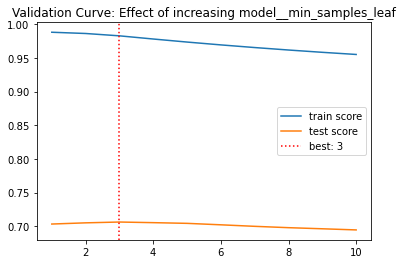

In [68]:
plot_vcurve(model=pipe_rand_rf,
    X_train=df_train,
    y_train=target_train,
    param='model__min_samples_leaf',
    param_range=range(1, 11, 1)
    )

From the validation curve we can see that the optimal value for the 'min_samples_leaf' parameter for our model is 3, so we will use this value and retrain our model.

In [81]:
best_params['min_samples_leaf'] = 3

pipe_rand_rf = Pipeline([
    ("preprocessor", preprocessor_rf),
    ("model", RandomForestRegressor(**best_params))
])

start = time.time()
# fit pipeline
pipe_rand_rf.fit(df_train, target_train)

stop = time.time()
print(f"Training time: {stop - start}s")

C:\Users\ignac\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Training time: 218.64510321617126s


In [70]:
evaluate(pipe_rand_rf, target_train, target_test)

Model Performance
R2 on test data: 0.8207386840207476
R2 on training data: 0.9739237224567114
RMSE on test data: 85.35001128934853


### Gradient Boosting Regressor - Grid Search CV

For the Gradient Boosting model, we decided to use the more brute-force method of tuning in a Grid Search CV. Since this type of algorithm is more sensitive to hyperparameter tuning, we can achieve more improvement by iterating through less parameters but evaluating every combination.

In [71]:
# Creating parameter grid
param_grid_gb = {
    "model__n_estimators": range(200, 500, 100),
    "model__max_features": np.linspace(0.1,0.8,8)
}

In [72]:
# Fitting paramgrid
grid = GridSearchCV(
    pipe_gb,
    param_grid_gb,
    scoring="neg_mean_absolute_error", 
    cv=2,
    n_jobs=-1
)

start=time.time()

grid.fit(df_train, target_train)

stop=time.time()
print(f"Training time: {stop-start}s")

C:\Users\ignac\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training time: 458.8691198825836s


In [73]:
grid.best_params_

{'model__max_features': 0.6, 'model__n_estimators': 300}

In [74]:
# scoring model
evaluate(grid, target_train, target_test)

Model Performance
R2 on test data: 0.8308194834166773
R2 on training data: 0.9316226798570544
RMSE on test data: 82.91545076604191


By just focusing on two key parameters we were able to improve our model's performance dramatically, both in terms of R2 on test data and RMSE.

Now, we have two different models (Random Forrest and Gradient Boosting) that perform to a standard we deem acceptable.

## Final Model - Voting Regressor

Since we were able to train two models with good performances, combining these two is a prudent next step. By combining the results of the two models we are able to leverage thier different approaches and cancel out their respective drawbacks. 

We can combine our models using a Voting Regressor. This allows us to impute both of our trained models and average their predictions to output a final result that reflects both of their calculations. 

In [75]:
# Training classifiers
model1 = pipe_rand_rf
model2 = grid

voting = VotingRegressor(estimators=[('rf', model1), ('gb', model2)], n_jobs=-1)

In [76]:
# Fitting Voting Regressor
voting.fit(df_train, target_train)

C:\Users\ignac\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


VotingRegressor(estimators=[('rf',
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               Index(['season', 'time_of_day', 'hum_level'], dtype='object')),
                                                           

In [77]:
evaluate(voting, target_train, target_test)

Model Performance
R2 on test data: 0.8482888144061876
R2 on training data: 0.9607782634755933
RMSE on test data: 78.51797561273851


Here we can see that this final model has the best performance out of all the models, both in terms of R2 on the test data and the RMSE.

## Final Results

In [78]:
def plot_results(model_list, df_test, target_test, fig_size, range_limit):
    df_test = df_test[range_limit[0]:range_limit[1]]
    target_test = target_test[range_limit[0]:range_limit[1]]
    
    fig, ax = plt.subplots(figsize=fig_size)
    results_df = pd.DataFrame(columns=['Index', 'Model', 'Result'])
    index_ls = []
    model_ls = []
    result_ls=[]
    
    for model in model_list:
        target_test_pred = model[1].predict(df_test)
        i = 0
        for value in target_test_pred:
            model_ls.append(model[0])
            result_ls.append(value)
            index_ls.append(i)
            i+=1
        i = 0
    for value in target_test.cnt:
            model_ls.append('Real Value')
            result_ls.append(value)
            index_ls.append(i)
            i+=1
    
    results_df['Index'] = index_ls
    results_df['Model'] = model_ls
    results_df['Result'] = result_ls
 
    ax = sns.lineplot(x = 'Index', y = 'Result', data = results_df, hue = 'Model').set(title = f"Model Predictions vs. Real Value (for values from {range_limit[0]} to {range_limit[1]})", xlabel = 'Value')

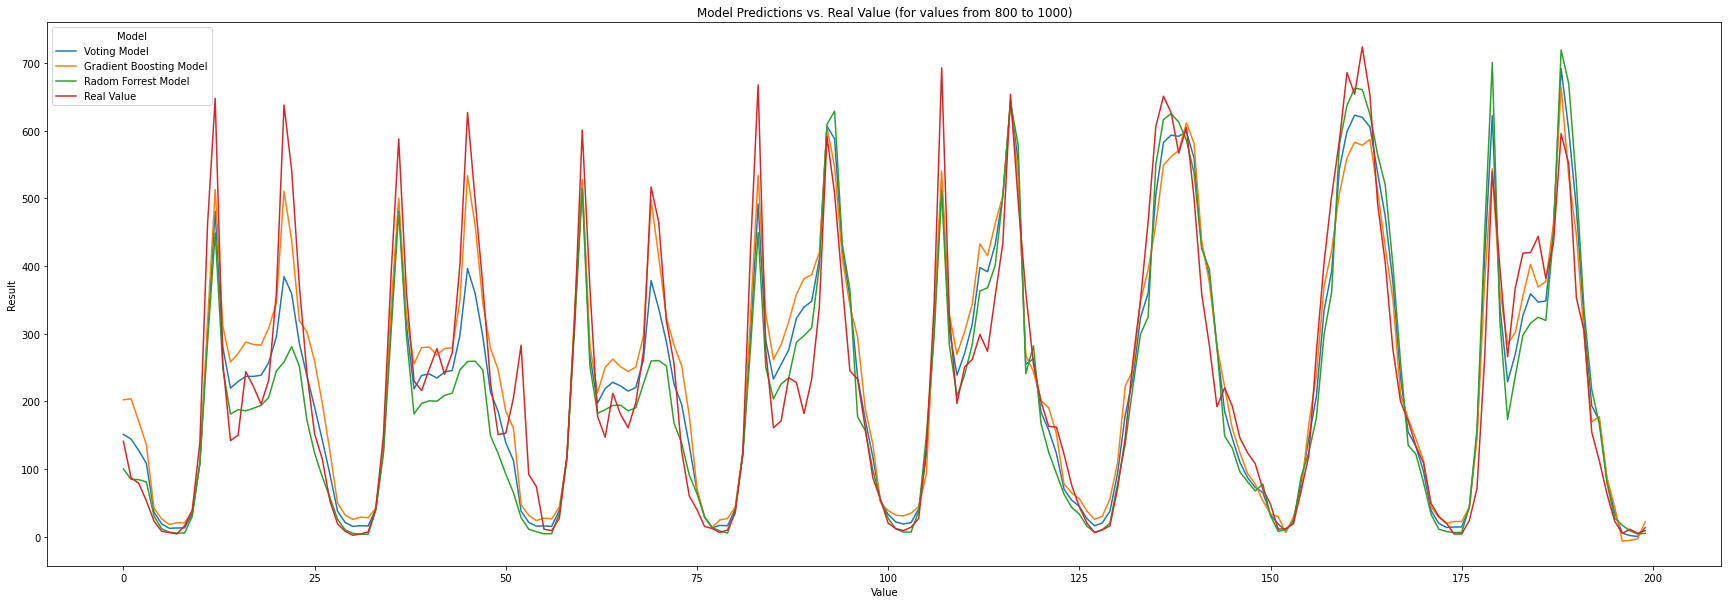

In [79]:
model_list = [['Voting Model', voting], ['Gradient Boosting Model', grid], ['Radom Forrest Model', pipe_rand_rf]]

plot_results(model_list, df_test, target_test, fig_size = (30, 10), range_limit = (800, 1000))

Using this chart we can explore the performance of the models we have created when compared to the real values of the data. We can change the change of the chart to limit the amount of data we are plotting to see in more detail what Result each model predicted.

From inspection in this graph we see several key insights. 	
* Each model could outperform any of the other in one instant
* The Voting Regressor Model was not always the closest to the real value
* Different models are able to capture different behavior in the real values

As we can see, no model is perfect. We trained our models to keep MSE down and to have the highest R2 value we could; however, this does not make them perfect at predicting the real world values. What this does show us is that through the process of iterating models and slowly refining them one change at a time, we are able to drastically improve out performance. With more time and resources any model can be bettered through this proccess. 

In [83]:
total_stop = time.time()

print(f"Total Notebook Runtime = {total_stop - total_start_time}")

Total Notebook Runtime = 13836.800390958786
